This code is a near-copy from https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/ for learning purposes. Slight modification was necessary due to API version differences.

All credit goes to the original author Cyrille Rossant.

In [59]:
import datetime
import numpy as np
import scipy as sp
import pandas as pd
import pyspark.pandas as ps
from pyspark import SparkFiles
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
%matplotlib inline

# spark = SparkSession.builder.master("spark://spark:7077").getOrCreate()
# spark.sparkContext.addFile('https://raw.githubusercontent.com/ipython-books/cookbook-2nd-data/master/weather.csv')

# df0 = ps.read_csv('file://' + SparkFiles.get('weather.csv'), na_values=(-9999), parse_dates=False)

df0 = pd.read_csv('https://raw.githubusercontent.com/ipython-books/cookbook-2nd-data/master/weather.csv', na_values=(-9999), parse_dates=['DATE'])

df = df0[df0['DATE'] >= '19940101']

df.head()

,STATION,DATE,PRCP,TMAX,TMIN
365,GHCND:FR013055001,1994-01-01,0.0,104.0,72.0
366,GHCND:FR013055001,1994-01-02,4.0,128.0,49.0
367,GHCND:FR013055001,1994-01-03,0.0,160.0,87.0
368,GHCND:FR013055001,1994-01-04,0.0,118.0,83.0
369,GHCND:FR013055001,1994-01-05,34.0,133.0,55.0


In [60]:
df_avg = df.dropna().groupby('DATE').mean(numeric_only = True)

df_avg.head()

,PRCP,TMAX,TMIN
DATE,,,
1994-01-01,178.666667,127.388889,70.333333
1994-01-02,122.000000,152.421053,81.736842
1994-01-03,277.333333,157.666667,95.555556
1994-01-04,177.105263,142.210526,95.684211
1994-01-05,117.944444,130.222222,75.444444


In [61]:
date = df_avg.index
temp = (df_avg['TMAX'] + df_avg['TMIN']) / 20

Text(0, 0.5, 'Mean temperature')

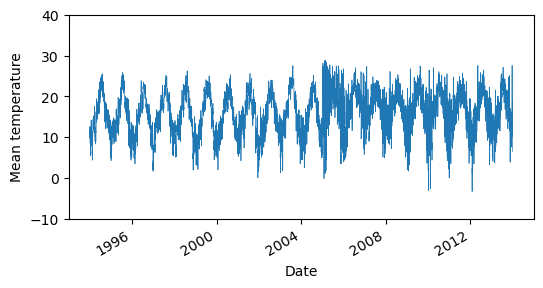

In [62]:
N = len(temp)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
temp.plot(ax=ax, lw=.5)
ax.set_ylim(-10, 40)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')

In [63]:
temp_fft = sp.fft.fft(temp.values)
temp_fft

array([117030.41834357   -0.j        ,  -1304.3080663 +4087.7221589j ,
          388.7379987 -1517.7214735j , ...,
          287.82461506-1545.90493039j,    388.7379987 +1517.7214735j ,
        -1304.3080663 -4087.7221589j ])

In [64]:
temp_psd = np.abs(temp_fft) ** 2
temp_psd

array([1.36961188e+10, 1.84106920e+07, 2.45459570e+06, ...,
       2.47266506e+06, 2.45459570e+06, 1.84106920e+07])

In [65]:
fftfreq = sp.fft.fftfreq(len(temp_psd), 1. / 365)
fftfreq

array([ 0.        ,  0.05012359,  0.10024718, ..., -0.15037078,
       -0.10024718, -0.05012359])

In [66]:
i = fftfreq > 0
i

array([False,  True,  True, ..., False, False, False])

Text(0, 0.5, 'PSD (dB)')

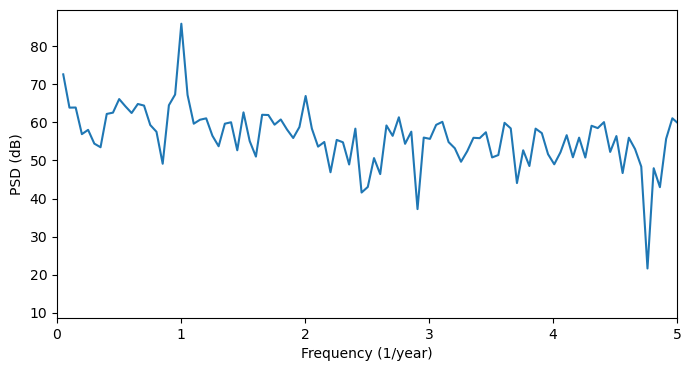

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('PSD (dB)')

In [68]:
temp_fft_bis = temp_fft.copy()
temp_fft_bis[np.abs(fftfreq) > 1.1] = 0

Text(0, 0.5, 'Mean temperature')

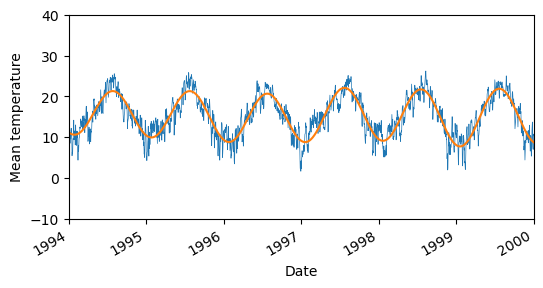

In [69]:
temp_slow = np.real(sp.fft.ifft(temp_fft_bis))

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
temp.plot(ax=ax, lw=.5)
ax.plot_date(date, temp_slow, '-')
ax.set_xlim(datetime.date(1994, 1, 1),
            datetime.date(2000, 1, 1))
ax.set_ylim(-10, 40)
ax.set_xlabel('Date')
ax.set_ylabel('Mean temperature')